In [8]:
# Last performance: 95%-96% validation
# Note: Data augmentation and extra layers did not help
# Try different optimizers

In [9]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [16]:
# train_datagen = ImageDataGenerator(brightness_range=[0.2,1.0], horizontal_flip=True, rotation_range=90)
def make_generator():
    train_datagen = ImageDataGenerator(brightness_range=[0.2,1.0], rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        directory="../data/CurrentTrainingData/train",
        target_size=(300, 300),
        color_mode="grayscale",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=91
    )
    return train_generator
train_generator = make_generator()

Found 34630 images belonging to 14 classes.


In [17]:
# valid_datagen = ImageDataGenerator(brightness_range=[0.2,1.0], horizontal_flip=True,rotation_range=90)
def make_generator():
    valid_datagen = ImageDataGenerator(brightness_range=[0.2,1.0], rescale=1./255)
    valid_generator = valid_datagen.flow_from_directory(
        directory="../data/CurrentTrainingData/val",
        target_size=(300, 300),
        color_mode="grayscale",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=17
    )
    return valid_generator
valid_generator = make_generator()

Found 5400 images belonging to 14 classes.


In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [19]:
# Model architecture
def create_model():
    sgd = SGD(lr=0.001)
    model = Sequential()
    model.add(Conv2D(filters=96, input_shape=(300,300,1), kernel_size=(11,11),strides=(4,4), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())    
    model.add(Flatten())
    model.add(Dense(4096, input_shape=(300*300*1,), activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.6))
    model.add(BatchNormalization())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(14, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
    return model
    
    

In [21]:
saveCheckpoint = ModelCheckpoint('an3sources_Adam.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 96)        11712     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       8

In [23]:
start = time()
history = model.fit_generator(generator = train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs = 25, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, callbacks=[saveCheckpoint], max_queue_size=20, workers=2)
print("Total Time taken to train the model: ", (time()-start) / 60 , )

Epoch 1/25
1082/1082 [==============================] - 140s 129ms/step - loss: 1.9164 - accuracy: 0.3793 - val_loss: 3.3912 - val_accuracy: 0.3862
Epoch 2/25
1082/1082 [==============================] - 115s 106ms/step - loss: 0.5541 - accuracy: 0.8018 - val_loss: 0.5744 - val_accuracy: 0.8246
Epoch 3/25
1082/1082 [==============================] - 116s 107ms/step - loss: 0.2845 - accuracy: 0.8988 - val_loss: 0.4388 - val_accuracy: 0.8923
Epoch 4/25
1082/1082 [==============================] - 117s 108ms/step - loss: 0.2140 - accuracy: 0.9262 - val_loss: 0.3141 - val_accuracy: 0.9217
Epoch 5/25
1082/1082 [==============================] - 113s 105ms/step - loss: 0.1574 - accuracy: 0.9460 - val_loss: 0.6908 - val_accuracy: 0.8558
Epoch 6/25
1082/1082 [==============================] - 116s 107ms/step - loss: 0.1360 - accuracy: 0.9549 - val_loss: 0.4190 - val_accuracy: 0.9115
Epoch 7/25
1082/1082 [==============================] - 117s 108ms/step - loss: 0.1080 - accuracy: 0.9635 - val_

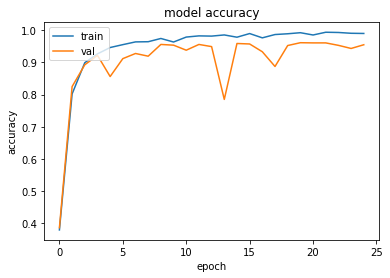

In [25]:
# Plotting the training accuracy and Validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

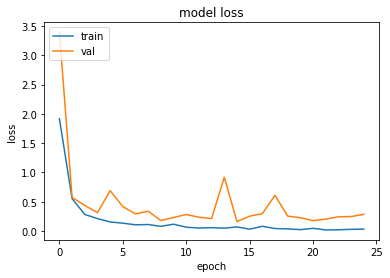

In [26]:
# Plotting training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()